# Roman Urdu Sentiment Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### **GOAL**
* Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided dataset below. 
* Maximize accuracy of the classifier with a special interest in being able to accurately detect negative sentiment.

### **Data Set Description** 
Classifier model developed below uses a dataset obtained form UCI Machine Learning Repository located <a href="http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set">here</a>

This dataset is authored by Zareen Sharf, from Shaheed Zulfiqar Ali Bhutto Institute of Science and Technology (SZABIST). Data set contains sentences in Urdu languate and it is tagged for sentiements either, Positive, Negative, or Neutral.

Sentences in Urdu are written in plain English for word processing rather than native Urdu fonts. Data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled.

### **Plan of Work** 

Sentiment analysis involves the following stages. 

* Loading and cleaning the data
* Exploratory data analysis
* Ommiting stop words or common words
* Creating new features
* Plotting most frequently used words
* Vectorizing sentences to build a matrix
* Training and testing the machine learning model
* Evaluating the machine learning model accuracy

In [2]:
# Loading required python packages and libraries
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from wordcloud import WordCloud,STOPWORDS

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [3]:
# Load the csv file using Pandas and print first 5 lines
data =pd.read_csv(r"C:\Users\PC\Desktop\sentiments\data set 1.csv",header=None)
data.head()

,0,1
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


### **Data Preprocessing**

In this step, data is preprocessed or cleaned for missing column names, incorrect values of sentiments, null values present in the text body. 

In [4]:
# Adding column names
data.columns =['body_text','sentiment']

In [5]:
# Print unique values in column 1 and 2
print ('Unique values of the sentiments are', data.sentiment.unique())


Unique values of the sentiments are ['Positive' 'Negative']


In [6]:
# 'Neative' sentiment will be most likely Negative, so it is replaced accordingly. 
data[data['sentiment']=='Neative']='Negative'

In [7]:
# Verify we replaced all the 'Neative'
print ('Unique values of the sentiments are', data.sentiment.unique())

Unique values of the sentiments are ['Positive' 'Negative']


In [8]:
# Checking Null values in the data
data.isna().sum()

body_text    0
sentiment    0
dtype: int64

In [9]:
# Dropping the text body row which has a null value
data = data.dropna(subset=['body_text'])

In [10]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [11]:
data.describe()

,body_text,sentiment
count,11300,11300
unique,11095,2
top,Good,Positive
freq,23,6013


### **Data Exploration**

From the data of sentiments, it looks like it is not balanced. There are more neutral comments than positive and negative comments. When the class distribution is unbalanced, accuracy is considered a poor choice of evaluation of classifier. This is due the fact that, it gives high scores to models which just predict the most frequent class.

Number of sentiments in each category are as below
Positive    6013
Negative    5287
Name: sentiment, dtype: int64

Perecentage sentiments in each category are as below
Positive    53.212389
Negative    46.787611
Name: sentiment, dtype: float64


<AxesSubplot:>

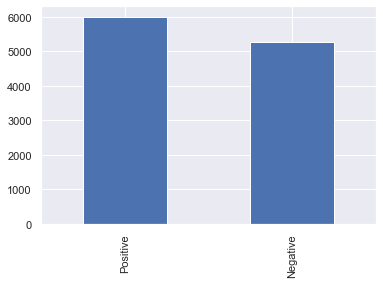

In [12]:
print ('Number of sentiments in each category are as below')
print (data.sentiment.value_counts())

print ('\nPerecentage sentiments in each category are as below')
print (data.sentiment.value_counts()/data.shape[0]*100)

data.sentiment.value_counts().plot(kind='bar')

In [13]:
# Dropping neutral sentiment sentences. 
data = data[data.sentiment != 'Neutral']

In [14]:
data = data.reset_index(drop=True)

In [15]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


<AxesSubplot:>

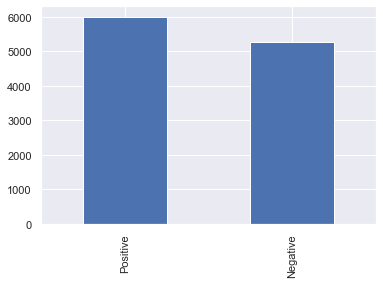

In [16]:
data.sentiment.value_counts().plot(kind='bar')

In [17]:
data.describe()

,body_text,sentiment
count,11300,11300
unique,11095,2
top,Good,Positive
freq,23,6013


### **Data Cleaning**

* Make all words lowercase
* Replace any stopwords

**Frequently Used Words**

It is important to check for frequency of words. This helps to identify any missing stopwods or its variation in spelling. Stopwords are then updated if required. 

* First we will create a long list containing all words in the text provided. 
* Unique words are then counted and words with significant number of occurances are reported. 
* Stopwords list is updated.
* Remaining high frequency words are then visually inspected using wordcloud by each sentiment.

From words in worldcloud of each sentiment, it can be noted that there is some overlapp of words between three classes. Though most of the words are different and correct. 

In [18]:
text_wordcloud = " ".join(word.lower() for word in data.body_text)
print ('There are total {} words in text provided.'.format(len(text_wordcloud)))

There are total 932608 words in text provided.


In [19]:
UrduStopWordList = [line.rstrip('\n') for line in open(r'C:\Users\PC\Desktop\sentiments\stopwords.txt')]

print (UrduStopWordList)

['nahi', 'nhi', 'nh', 'ney', 'nai', 'nay', 'chi', 'ni', 'na', 'k', 'ye', 'to', 'hai', 'i', 'kisi', 'sy', 'hain', 'or', 'tak', 'ek', 'aik', 'kiya', 'liya', 'diya', 'dete', 'unhon', 'unhen', 'sey', 'kiye', 'mujhe', 'mjhe', 'bana', 'hue', 'aur', 'wo', 'u', 'aa', 'woh', 'ai', 'aisa', 'waisa', 'mera', 'mere', 'mery', 'meri', 'muzhe', 'mai', 'hum', 'khud', 'acha', 'per', 'har', 'tag', 'bat', 'baat', 'pr', 'he', 'hamara', 'jahan', 'tumhara', 'tm', 'apka', 'apke', 'walon', 'lekin', 'lakin', 'kitna', 'ke', 'hota', 'hon', 'kab', 'kb', 'kabhi', 'sirf', 'hoti', 'hote', 'magar', 'app', 'agar', 'agr', 'pta', 'jab', 'inhe', 'inho', 'o', 'in', 'sath', 'esa', 'kaha', 'key', 'kahan', 'jis', 'kia', 'ayi', 'hy', 'main', 'mein', 'me', 'hein', 'hn', 'ki', 'tha', 'ta', 'koi', 'ko', 'woh ', 'bhi', 'py', 'yeh', 'raha', 'rha', 'hota', 'ho', 'ga', 'g', 'ka', 'leye', 'lye', 'kr', 'kar', 'kry', 'ker', 'lye', 'liye', 'liya', 'hotay', 'waisay', 'gya', 'gaya', 'gae', 'kch', 'kuch', 'ab', 'q', 'in', 'a', 'and', 'they'

## **Feature Engineering**

In this step following new features are introduced.

* Length of text field
* Number of punctuations in the sentence body 
* TFIDF vectorization used to create vector of words

It can be noted that length of the sentence changes for different clasess. Punctuation count variation between different class is not significant. Emoji count is small but helps in improving accuracy slightly. 

In [20]:
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))

punct = string.punctuation

def count_punct(text):
    count = sum([1 for char in text if char in punct])
    return count

data['punct_count'] = data['body_text'].apply(lambda x: count_punct(x))

data.head()

,body_text,sentiment,body_len,punct_count
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,73,0
1,sahi bt h,Positive,7,0
2,"Kya bt hai,",Positive,9,1
3,Wah je wah,Positive,8,0
4,Are wha kaya bat hai,Positive,16,0


In [21]:
data.head()

,body_text,sentiment,body_len,punct_count
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,73,0
1,sahi bt h,Positive,7,0
2,"Kya bt hai,",Positive,9,1
3,Wah je wah,Positive,8,0
4,Are wha kaya bat hai,Positive,16,0


### Split into train/test


In [22]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct_count']],\
                                                    data['sentiment'], test_size=0.2,random_state=42,\
                                                    stratify=data['sentiment'])

In [23]:
y_train.describe()

count         9040
unique           2
top       Positive
freq          4810
Name: sentiment, dtype: object

In [24]:
def clean_text(text):
    #Change each character to lowercase and avoid any punctuation. Finally join word back. 
    text = "".join([char.lower() for char in text if char not in string.punctuation])
    
    # Use non word characters to split the sentence
    tokens = re.split('\W+', text)

    # Remove the stop words - commonly used words such as I, we, you, am, is etc in Urdu language 
    # that do not contribute to sentiment. 
    text = [word for word in tokens if word not in UrduStopWordList]
    return text

data_clean = data['body_text'].apply(lambda x: clean_text(x))
pd.set_option('max_colwidth', 800)
data_clean.head(10)

0                                    [sai, kha, her, bus, hal, kal, bi, aj, aj, bi, aus, say, bus]
1                                                                                       [sahi, bt]
2                                                                                             [bt]
3                                                                                   [wah, je, wah]
4                                                                                 [are, wha, kaya]
5                                                                                     [wah, likhi]
6                                                                       [wha, itni, sari, khubiya]
7                                                                                  [itni, khubiya]
8                                                     [allah, rehm, farma, zalimo, hidayat, ameen]
9    [please, everyone, allah, swt, naam, hamesha, bary, lawzo, likha, kary, zaat, say, bari, hey]
Name: body

### Vectorize text

Sentiment text classifier can not directly classify text. Machine learning models mainly expect text to be tranformed into a numerical form. 

This is done by converting sentences into vector of numbers. Each column indicates a word and frequency of words. This process is a way of feature extraction and termed as Bag of Words. It is called bag of words, because it does not track which words comes after another (order of words). 

In [35]:
# Function clean_text used to clean the sentiment data before vectorizing to remove stop words and punctuations. 
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1 with norm='l2', but not set
# ngram_range is set to (1, 2) to consider both unigrams and bigrams  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer(lowercase=False, stop_words=None)

#tfidf_vect = TfidfVectorizer(analyzer=clean_text) 
#tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

#tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
#tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

tfidf_vect_fit = cv.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

In [36]:
X_train_vect = pd.concat([X_train[['body_len', 'punct_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct_count,0,1,2,3,4,5,6,7,...,26152,26153,26154,26155,26156,26157,26158,26159,26160,26161
0,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,125,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_train_vect.shape

(9040, 26164)

### Building Machine Learning Models

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import time

In [29]:
# n_jobs = -1 for building parallel 150 decision trees. 
# Max_depth = None means it will build decision tree until minminzation of loss
#rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1,class_weight="balanced",random_state=42)

#rf_model = rf.fit(X_train_vect, y_train)
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=500, random_state=0)
model_dec.fit(X_train_vect, y_train)
y_pred_rf = model_dec.predict(X_test_vect)

acc = accuracy_score(y_test, y_pred_rf)
precision, recall, fscore, train_support = score(y_test, y_pred_rf, labels='Positive', average='macro')


print('Precision: {} / Recall: {} / F1 score: {} /Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore, 3),\
                                                                       round(acc,3)))    


c:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Precision: 0.663 / Recall: 0.663 / F1 score: 0.661 /Accuracy: 0.661


In [30]:
print ('Labels of the classes are as below. These are required when generate classification report')
print (rf.classes_)

Labels of the classes are as below. These are required when generate classification report


NameError: name 'rf' is not defined

**Classification report for Random Forest classifier**

In [ ]:
print ('Classification Report for Random Forest Classifier:\n',classification_report(y_test, y_pred_rf,digits=3))
#print ('\nConfussion matrix for Random Forest Classifier:\n'),confusion_matrix(y_test,  y_pred_rf,)

In [ ]:
cm = confusion_matrix(y_test,y_pred_rf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(2), rf.classes_, fontsize=20)
plt.yticks(range(2), rf.classes_, fontsize=20)
plt.show()